In [1]:
# %%
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import anndata as ad
import tensorflow as tf
import pickle
from tensorflow_probability import math as tm
tfk = tm.psd_kernels

2024-04-22 23:49:47.885083: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 23:49:47.916334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from nsfpaper.models import sf
from nsfpaper.utils import misc,preprocess,training,postprocess,visualize

# Running NSF

## Load the data

In [6]:
counts = pd.read_csv("../data/sub7_cell_by_gene.csv")
X = pd.read_csv("../data/sub7_location.csv")


## Create anndata file 

In [10]:
adata = ad.AnnData(counts)
adata.obsm["spatial"] = X.to_numpy()
adata.layers["counts"] = counts.to_numpy()

/home/rlaursen/miniconda3/envs/def/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Load the model

In [11]:
D,Dval = preprocess.anndata_to_train_val(adata, layer="counts", train_frac=0.9,
                                         flip_yaxis=False) # train_frac decides how much to put in the train and test set 
Ntr,J = D["Y"].shape
Xtr = D["X"]

Dtf = preprocess.prepare_datasets_tf(D, Dval = Dval)

In [12]:
L = 5 #number of components
Z = misc.kmeans_inducing_pts(Xtr, 1000)
M = Z.shape[0] #number of inducing points
ker = tfk.MaternThreeHalves

## Train the model

In [21]:
fit = sf.SpatialFactorization(J, L, Z, psd_kernel=ker, nonneg=True, lik="poi")
fit.init_loadings(D["Y"], X=Xtr, sz=D["sz"])
tro = training.ModelTrainer(fit, lr = 0.0001)

## save output

In [23]:
listout = [fit,tro.loss,tro.wtime]

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

save_object(listout,"nsf_result/sub7_output.pkl")

In [24]:
with open('nsf_result/sub7_output.pkl', 'rb') as f:
    listout = pickle.load(f)

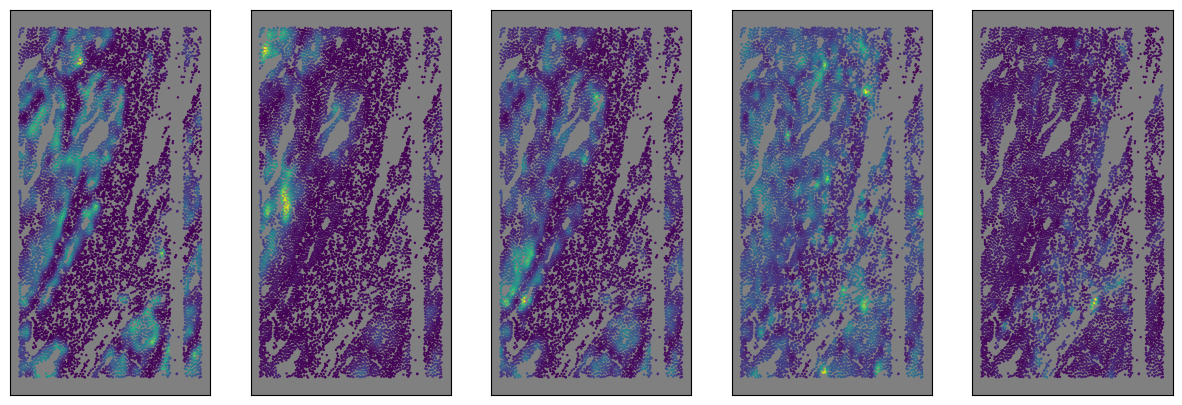

In [26]:
#%% NSF postprocessing and visualization
insf = postprocess.interpret_nsf(listout[0],Xtr,S=1000,lda_mode=False)
Fplot = insf["factors"]
fig,axes=visualize.multiheatmap(Xtr, Fplot, (1,L), cmap="viridis", s = 0.5, figsize = [15,5])


In [ ]:
insf["loadings"] # the loadings for the different genes

In [13]:
fit.length_scale

<TransformedVariable: name=gp_kernel_length_scale, dtype=float32, shape=[2], fn="softplus", numpy=array([0.10054377, 0.10053632], dtype=float32)>